In [1]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
from skimage import io
import random
import os
import time
import copy
import math
import numpy as np
import itertools
from scipy.stats import wasserstein_distance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#prepare the data

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.RandomResizedCrop(299),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.480, 0.485, 0.418], [0.230, 0.227, 0.259])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(311),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.480, 0.485, 0.418], [0.230, 0.227, 0.259])
    ]),
    'test': transforms.Compose([
        transforms.Resize(311),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.480, 0.485, 0.418], [0.230, 0.227, 0.259])
    ]),
    'selected': transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.RandomResizedCrop(299),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.480, 0.485, 0.418], [0.230, 0.227, 0.259])
    ]),
}

train_imagefolder = datasets.ImageFolder('CUB_split/train',data_transforms['train'])
classes = train_imagefolder.classes

train_dataloader = torch.utils.data.DataLoader(train_imagefolder,batch_size=32,
                                                 shuffle=True,num_workers=4,drop_last=True)

CUB_dir = 'CUB_split/'
valid_imagefolder = datasets.ImageFolder(CUB_dir+'valid',transform=data_transforms['valid'])
test_imagefolder = datasets.ImageFolder(CUB_dir+'test',transform=data_transforms['test'])
selected_imagefolder = datasets.ImageFolder('inat_selected_classes_100',transform=data_transforms['selected'])
imagefolders = {'train':train_imagefolder,
               'valid':valid_imagefolder,
               'test':test_imagefolder,
               'selected':selected_imagefolder}

CUB_dataloaders = {x: torch.utils.data.DataLoader(imagefolders[x], batch_size=32,
                         num_workers=4,shuffle=True,drop_last=True)
                         for x in ['valid','test','selected']}
CUB_dataloaders.update({'train':train_dataloader})


dataset_sizes = {'train':len(train_imagefolder), 'valid':len(valid_imagefolder),
                     'test':len(test_imagefolder),'selected':len(selected_imagefolder)}
class_names = train_imagefolder.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

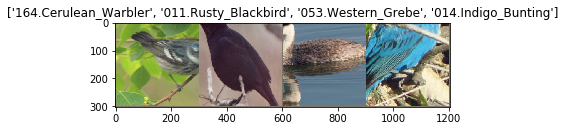

In [10]:
#display a few pics
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(CUB_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
#train function
def train_model(model,fc1,fc2, dataloaders, criterion, optimizer, scheduler, num_epochs=25,mode = 0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            selected_running_corrects = 0
            
            for target, selected in itertools.zip_longest(dataloaders[phase],dataloaders['selected']):
                
                if type(target) != type(None):
                    (inputs, labels) = target
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                if (type(selected) != type(None) ):
                    (selected_inputs, selected_labels) = selected
                    selected_inputs = selected_inputs.to(device)
                    selected_labels = selected_labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if (type(target) != type(None) ):
                        outputs = fc1(model(inputs))
                        _, preds = torch.max(outputs, 1)

                    if(type(selected) != type(None)):
                        selected_outputs = fc2(model(selected_inputs))
                        _, selected_preds = torch.max(selected_outputs, 1)
                        
                    
                    if(type(selected) != type(None)) and (type(target) != type(None) ):
                        #if there are both original data and selected data, then combine the loss
                        loss = 0.5*criterion(outputs, labels)+0.5*criterion(selected_outputs,selected_labels)
                        
                    elif (type(selected) != type(None)) and (type(target) == type(None) ):
                        loss = criterion(selected_outputs,selected_labels)
                        
                    elif (type(selected) == type(None)) and (type(target) != type(None) ):
                        loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if (type(target) != type(None) ):
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if(type(selected) != type(None)):
                    selected_running_corrects += torch.sum(selected_preds == selected_labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            selected_epoch_acc =  selected_running_corrects.double() / dataset_sizes['selected']

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print('running corrects: ',running_corrects,' dataset_size: ',dataset_sizes[phase])
            print('selected running corrects: ',selected_running_corrects,' dataset_size: ',dataset_sizes['selected'])

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('best model updated')
            
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'
                  .format(time_elapsed // 60, time_elapsed % 60))


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
#prepare the model

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model1 = models.inception_v3(pretrained=True)
num_ftrs = model1.fc.in_features
model1.fc = Identity()#nn.Linear(num_ftrs, len(class_names))

model1 = model1.to(device)
model1.aux_logits=False

fc1 = nn.Linear(num_ftrs, 200)
fc2 = nn.Linear(num_ftrs, 100)
fc1 = fc1.to(device)
fc2 = fc2.to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model1.parameters(), lr=0.0006)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.5)

In [6]:
model1 = train_model(model1,fc1,fc2, CUB_dataloaders,criterion, optimizer_ft, exp_lr_scheduler,
                    num_epochs=120)

Epoch 0/119
----------
train Loss: 3.7154 Acc: 0.0692
running corrects:  tensor(648, device='cuda:0')  dataset_size:  9369
selected running corrects:  tensor(4332, device='cuda:0')  dataset_size:  8878
valid Loss: 3.1753 Acc: 0.1611
running corrects:  tensor(197, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(4307, device='cuda:0')  dataset_size:  8878
best model updated
Training complete in 6m 15s

Epoch 1/119
----------
train Loss: 2.9963 Acc: 0.1876
running corrects:  tensor(1758, device='cuda:0')  dataset_size:  9369
selected running corrects:  tensor(5181, device='cuda:0')  dataset_size:  8878
valid Loss: 2.8151 Acc: 0.2813
running corrects:  tensor(344, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(4824, device='cuda:0')  dataset_size:  8878
best model updated
Training complete in 12m 29s

Epoch 2/119
----------
train Loss: 2.5339 Acc: 0.2984
running corrects:  tensor(2796, device='cuda:0')  dataset_size:  9369
selected running

valid Loss: 1.1125 Acc: 0.7907
running corrects:  tensor(967, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(7304, device='cuda:0')  dataset_size:  8878
best model updated
Training complete in 125m 9s

Epoch 20/119
----------
train Loss: 0.6958 Acc: 0.7736
running corrects:  tensor(7248, device='cuda:0')  dataset_size:  9369
selected running corrects:  tensor(7851, device='cuda:0')  dataset_size:  8878
valid Loss: 0.9897 Acc: 0.8119
running corrects:  tensor(993, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(7360, device='cuda:0')  dataset_size:  8878
best model updated
Training complete in 131m 27s

Epoch 21/119
----------
train Loss: 0.6830 Acc: 0.7808
running corrects:  tensor(7315, device='cuda:0')  dataset_size:  9369
selected running corrects:  tensor(7851, device='cuda:0')  dataset_size:  8878
valid Loss: 1.0149 Acc: 0.7915
running corrects:  tensor(968, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(

valid Loss: 0.9081 Acc: 0.8177
running corrects:  tensor(1000, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(7710, device='cuda:0')  dataset_size:  8878
best model updated
Training complete in 251m 3s

Epoch 40/119
----------
train Loss: 0.4212 Acc: 0.8673
running corrects:  tensor(8126, device='cuda:0')  dataset_size:  9369
selected running corrects:  tensor(8273, device='cuda:0')  dataset_size:  8878
valid Loss: 0.8943 Acc: 0.8209
running corrects:  tensor(1004, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(7752, device='cuda:0')  dataset_size:  8878
best model updated
Training complete in 257m 20s

Epoch 41/119
----------
train Loss: 0.4252 Acc: 0.8668
running corrects:  tensor(8121, device='cuda:0')  dataset_size:  9369
selected running corrects:  tensor(8265, device='cuda:0')  dataset_size:  8878
valid Loss: 0.8316 Acc: 0.8250
running corrects:  tensor(1009, device='cuda:0')  dataset_size:  1223
selected running corrects:  tens

train Loss: 0.3430 Acc: 0.8934
running corrects:  tensor(8370, device='cuda:0')  dataset_size:  9369
selected running corrects:  tensor(8369, device='cuda:0')  dataset_size:  8878
valid Loss: 0.8344 Acc: 0.8446
running corrects:  tensor(1033, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(7882, device='cuda:0')  dataset_size:  8878
best model updated
Training complete in 376m 45s

Epoch 60/119
----------
train Loss: 0.3354 Acc: 0.8963
running corrects:  tensor(8397, device='cuda:0')  dataset_size:  9369
selected running corrects:  tensor(8352, device='cuda:0')  dataset_size:  8878
valid Loss: 0.8400 Acc: 0.8455
running corrects:  tensor(1034, device='cuda:0')  dataset_size:  1223
selected running corrects:  tensor(7863, device='cuda:0')  dataset_size:  8878
best model updated
Training complete in 383m 2s

Epoch 61/119
----------
train Loss: 0.3317 Acc: 0.8977
running corrects:  tensor(8411, device='cuda:0')  dataset_size:  9369
selected running corrects:  tens

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda

KeyboardInterrupt: 

In [5]:
#torch.save(model1.state_dict(), './multi_augmentation.pth')
model1.fc = fc1

In [7]:
# TODO: Do validation on the test set
def check_accuracy_on_test(model, testloader):    
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    
    print('Accuracy of the network on the test images: ',( correct / float(total)))
    print('correct: ',correct,' total: ',total)
model1.eval()
check_accuracy_on_test(model1,CUB_dataloaders['test'])

Accuracy of the network on the test images:  0.8209459459459459
correct:  972  total:  1184
